# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
device = torch.device('cpu')

torch.manual_seed(0)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]

        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)

            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)

            image_array.append(array)

        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64)
# dataset = BrainMRIDataset(data_dir)

print(dataset)

#upload model
model_path = path_to_project_root + 'models/brain_tumor_cnn.pt'
try:
    model = torch.load(model_path)
    model.eval()
except Exception:
    print('proceed with training')

                                         image  labels
0   ../../../data/brain_tumor_imgs/no/4 no.jpg       0
1   ../../../data/brain_tumor_imgs/no/no 4.jpg       0
2   ../../../data/brain_tumor_imgs/yes/Y89.JPG       1
3  ../../../data/brain_tumor_imgs/yes/Y249.JPG       1
4   ../../../data/brain_tumor_imgs/yes/Y34.jpg       1
proceed with training


#### MODEL with SyMPC wraper

In [4]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3) #orig 1, 256
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)  #orig 256,32
        self.linear1 = self.torch_ref.nn.Linear(30,64) # orig 62, 128
        self.linear2 = self.torch_ref.nn.Linear(64,32) # orig 128, 64
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2) #orig 126976,2

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
#         print(x.shape)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [5]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200
plot = False

def train(model, dataset, num_epochs = 100, batch_size = 32):
    model.train()

    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(len(dataset)//batch_size):
            optimizer.zero_grad()
            image, label = dataset[i*batch_size:(i+1)*batch_size]
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
        if epoch%10 == 0:
            print(f'Epochs: {epoch} Loss: {total_loss/i}')
        loss_list.append(total_loss/batch_size)
    return loss_list
loss_list = train(model, dataset, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

Epochs: 0 Loss: 435.5070495605469
Epochs: 10 Loss: 0.9941741824150085
Epochs: 20 Loss: 0.6993613243103027
Epochs: 30 Loss: 0.6285467743873596
Epochs: 40 Loss: 0.5405978560447693
Epochs: 50 Loss: 0.4794703722000122
Epochs: 60 Loss: 0.4685600996017456
Epochs: 70 Loss: 0.42852485179901123
Epochs: 80 Loss: 0.4123987853527069
Epochs: 90 Loss: 0.3991747796535492
Epochs: 100 Loss: 0.3776874542236328
Epochs: 110 Loss: 0.3659858703613281
Epochs: 120 Loss: 0.4430657625198364
Epochs: 130 Loss: 0.37452462315559387
Epochs: 140 Loss: 0.3520364761352539
Epochs: 150 Loss: 0.32891741394996643
Epochs: 160 Loss: 0.3123752176761627
Epochs: 170 Loss: 0.3109622895717621
Epochs: 180 Loss: 0.30621328949928284
Epochs: 190 Loss: 0.30333611369132996


In [7]:
#Evaluate model

def test(num_of_predictions):
    model.eval()
    correctly_predicted = 0
    with torch.no_grad():
        for idx, (image, label) in enumerate(dataset):
            pred = model.forward(image.float())
            pred = torch.argmax(pred, dim=1)
            # print(f"PRED: {pred} - LABEL:{label}")
            correctly_predicted += (pred == label)
            # print(correctly_predicted)
            if idx == num_of_predictions: break
    accuracy = correctly_predicted.sum() / float(num_of_predictions)
    print(f'Test Accuracy of the model on the test images: {accuracy:.2f}')
test(250)

Test Accuracy of the model on the test images: 0.84


tensor([[ 0.2635, -0.2654]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-5.0242,  5.0744]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-2.8139,  2.7689]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-2.9767,  3.0455]], grad_fn=<AddmmBackward>)
tensor([[-3.2609,  3.4059]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[ 1.3051, -1.2815]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-0.2797,  0.2758]], grad_fn=<AddmmBackward>)
tensor([[-33.0088,  32.8813]], grad_fn=<AddmmBackward>)
tensor([[-2.8525,  2.8069]], grad_fn=<AddmmBackward>)
tensor([[ 32.3963, -32.4803]], grad_fn=<AddmmBackward>)
tensor([[ 27.8398, -27.8078]], grad_fn=<AddmmBackward>)
tensor([[-5.0681,  5.1

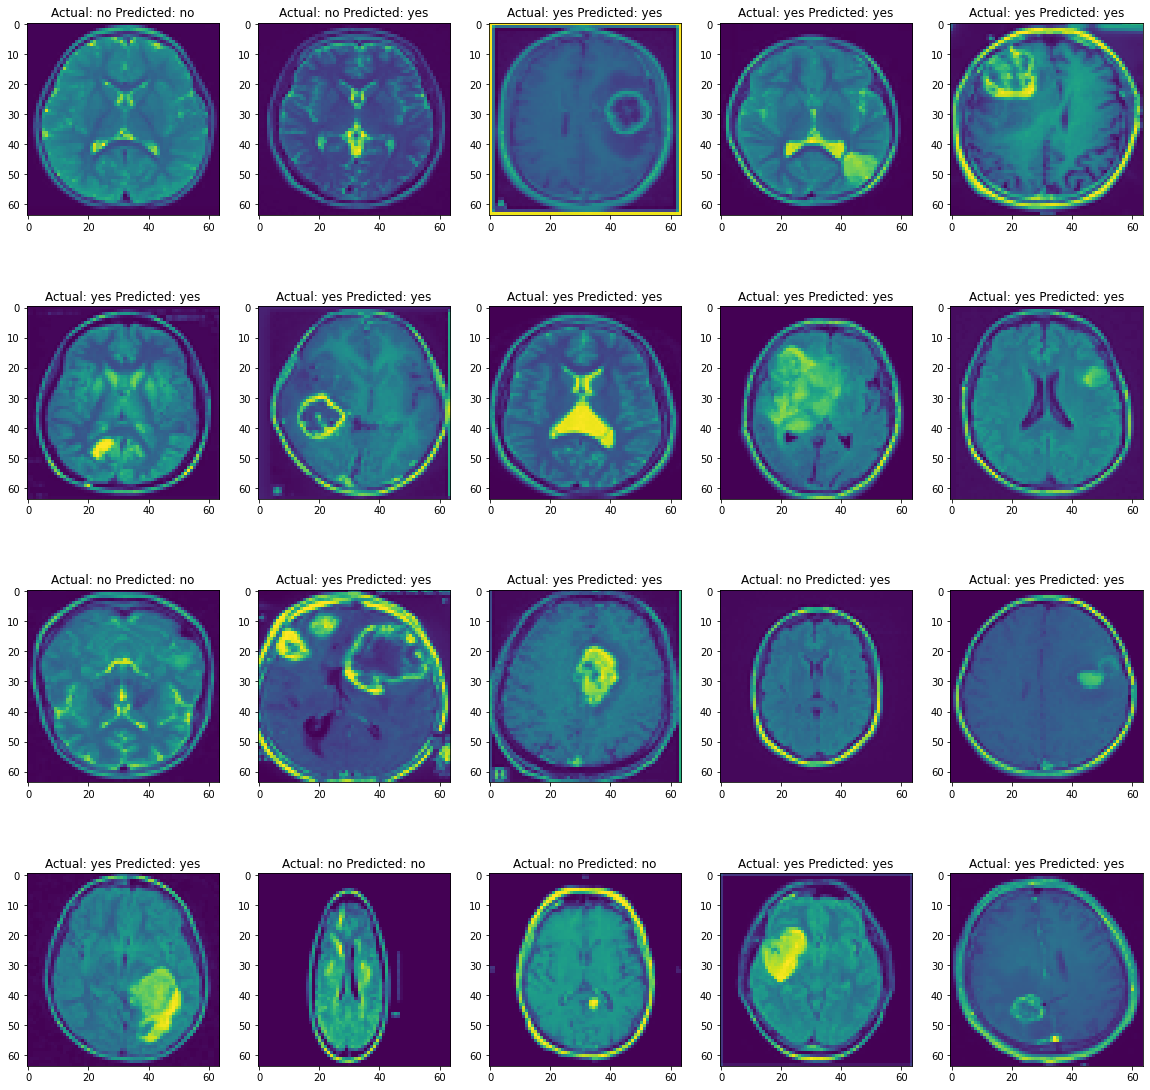

In [8]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model(data.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()

#### ORIGINAL MODEL

In [9]:
# class BrainTumorModelOriginal(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1,128,kernel_size=3),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(128,32,kernel_size=2)
#         )
#         self.linear1 = nn.Linear(30,64)
#         self.linear2 = nn.Linear(64,32)
#         self.flat = nn.Flatten(1)
#         self.linear3 = nn.Linear(30720,2)
#         # self.linear3 = nn.Linear(63488,2)

#     def forward(self,x):
#         # print(x.shape)
#         x = F.relu(self.conv1(x))
#         # print(x.shape)
#         x = F.relu(self.linear1(x))
#         # print(x.shape)
#         x = self.linear2(x)
#         # print(x.shape)
#         x = self.flat(x)
#         # print(x.shape)
#         x = self.linear3(x)

#         return x

In [10]:
# model_orig = BrainTumorModelOriginal()
# print(model_orig)

In [11]:

# model_orig = BrainTumorModelOriginal()
# epochs = 100
# batch_size = 32
# loss_list = []
# for epoch in range(epochs):
#     total_loss = 0
#     for n in range(len(dataset)//batch_size):

#         data,target = dataset[n*batch_size:(n+1)*batch_size]

#         ypred = model_orig.forward(data.float())
#         loss = loss_fn(ypred,target)

#         total_loss += loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     loss_list.append(total_loss/batch_size)
#     if epoch%10 == 0:
#         print(f'Epochs: {epoch} Loss: {total_loss/n}')
#         break
# # in case decrease size in half

In [12]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
# from sympc.protocol import Falcon

In [13]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    data_pointers = []

    split_size = int(len(data)/len(session.parties))+1
    for index in range(0,len(session.parties)):
        ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        data_pointers.append(ptr)

    return data_pointers

In [14]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [15]:
ptrs = []
labels = []
for i, (img, lbl) in enumerate(dataset):
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)
    if i == 10: break
ptrs

[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,


In [16]:
dataset[0][0][0][0][0]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 4, 6, 7, 6, 2, 0, 0, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2], dtype=torch.uint8)

In [17]:
mpc_model = model.share(session)
mpc_model

In [18]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2021-11-10T16:22:13.248313+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84fb09af5b004be6a6c37eee49318865>.
[2021-11-10T16:22:13.258022+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20bc23ba18d54a45930c30dbaa3d6068>.
[2021-11-10T16:23:18.774630+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5fa4e4313db4f71b1b3f9079a38f9c8>.
[2021-11-10T16:23:18.782018+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fdf3e324041046c8b8bceb360794e28d>.
[2021-11-10T16:23:51.986299+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 570d34bd6aac48a88881c109ca6ee582>.
[2021-11-10T16:23:51.989323+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4479d49c29b0420

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3634.8994,  3607.7695]])


[2021-11-10T16:24:01.538458+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1cf65a944ad4273a96b927ee9f76d27>.
[2021-11-10T16:24:01.553648+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19e1c3f91bc74535b1597f17f7c428cc>.
[2021-11-10T16:24:01.567383+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4cfad8c69fd4562b81193b8522dfc55>.
[2021-11-10T16:24:01.570110+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 156f59363ebe44ffa80e649f64d6a625>.
[2021-11-10T16:24:01.578596+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d429447669e4b3290d951f10b2f61de>.
[2021-11-10T16:24:01.580985+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a573564b81f5413

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1278.4521, -1293.9486]])


[2021-11-10T16:25:49.044162+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a700c7b7ecaf4b639467c39b4f361331>.
[2021-11-10T16:25:49.059196+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21789625244b4b9da416d4b0c622a6e2>.
[2021-11-10T16:25:49.074031+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ad5436e498649f4b62dd1bdbc42c85a>.
[2021-11-10T16:25:49.077059+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90fa9ac6d8d24cbc9e1771f7d4f3d82e>.
[2021-11-10T16:25:49.086261+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 921f0eb30d7246f1acd279287067d675>.
[2021-11-10T16:25:49.089192+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c65173981c8b4bc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-495.4555,  473.4085]])


[2021-11-10T16:27:36.136365+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: caf1efbd0eae46df96b3af54f332cf92>.
[2021-11-10T16:27:36.144509+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59fb5404781c4581b12ce9a2eca4b15e>.
[2021-11-10T16:27:36.324206+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bf2b35acada42df99f69f404df396f2>.
[2021-11-10T16:27:36.327001+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17f9772c1b814efab33586c31bd66ae3>.
[2021-11-10T16:28:41.179658+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b411dbbfe824811aca2fc92c650d2de>.
[2021-11-10T16:28:41.192451+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b56471ead9344d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-702.4529,  656.1356]])


[2021-11-10T16:29:25.348281+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8bbc71179a72411da2b907273ba182e6>.
[2021-11-10T16:29:25.356666+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3026d32d775f4e87be9a596bc7e25c99>.
[2021-11-10T16:29:25.595168+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 201cdc614c2b4a94834c892f7b513dae>.
[2021-11-10T16:29:25.597944+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1956b288c0b844dfad1db1af16016ce8>.
[2021-11-10T16:30:32.807774+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a6a5e9898bc14ec79f8c556a0c868ab4>.
[2021-11-10T16:30:32.819121+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4a8ba7ef15b4f9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1833.3574, -1818.1976]])


[2021-11-10T16:31:16.845663+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 995e4fb405d6419e9f6a4bfcf740877f>.
[2021-11-10T16:31:16.859934+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 848651b040484f47b03f12189454beb6>.
[2021-11-10T16:31:16.876230+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 656653f9802041b1a5ca1e4d324c5cf1>.
[2021-11-10T16:31:16.878987+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b64f1b78435c4c329f2fd16dafba6683>.
[2021-11-10T16:31:16.882964+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6945b08f1a684567b958310e9209a3ef>.
[2021-11-10T16:31:16.885294+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2c4aa45a88d438

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1437.1768,  1398.6637]])


[2021-11-10T16:33:11.221991+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f609861b85174384a5f260aefbe20f08>.
[2021-11-10T16:33:11.238697+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 576b3d822fa14d5187f098b44efd3ffb>.
[2021-11-10T16:33:11.259701+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0eb9cd9c9bda4d209d2ab0ccb9740ce7>.
[2021-11-10T16:33:11.263046+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53d2f36f13334b5ab80cd811b5247d6d>.
[2021-11-10T16:33:11.272508+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9ce627624844bd3ae9bde2b4a5701f6>.
[2021-11-10T16:33:11.275271+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19004e93b58a4af

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2221.3757, -2243.6699]])


[2021-11-10T16:35:01.162138+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec76ba3b90e246db9feca1212b9af10b>.
[2021-11-10T16:35:01.170534+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ed2369fd47147e7960135d5b82336dd>.
[2021-11-10T16:35:01.180105+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f356d3cdce904f2bae24b36a88ec1dc2>.
[2021-11-10T16:35:01.182609+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf5138f7c1ed4803a1d87ae0ce93e9ca>.
[2021-11-10T16:35:01.191131+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4461b3558fc4eed897f8e62e0961eda>.
[2021-11-10T16:35:01.193619+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfc393b28258480

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1322.7993,  1337.5928]])


[2021-11-10T16:36:56.201169+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba15e682b700412f97784a39490b99c3>.
[2021-11-10T16:36:56.211402+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44275ee046fd4036b74391ea169ecba4>.
[2021-11-10T16:36:56.215885+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c2984f13cf649bf88a589d70b203c10>.
[2021-11-10T16:36:56.218612+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 479e36bcca6e4e75978777b4c2a69248>.
[2021-11-10T16:36:56.415972+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a7442c57df74fd9ae58f8b8ad837b91>.
[2021-11-10T16:36:56.418883+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 398267b3e8254f9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3216.4272,  3170.8274]])


[2021-11-10T16:38:49.791528+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dad0625221745b08bddcc83f41e6839>.
[2021-11-10T16:38:49.805590+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d85afe82edd44edc8bb1d073ea1895a2>.
[2021-11-10T16:38:49.821311+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7eb6c08d34ff41b183a5437be6cdbf45>.
[2021-11-10T16:38:49.824449+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d543730674243ca916ca83d307f0ade>.
[2021-11-10T16:38:49.833878+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e57a5bb7edf049228e56325f5261b6dd>.
[2021-11-10T16:38:49.836782+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fc0d722d7af497

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1378.0419,  1390.6135]])


[2021-11-10T16:40:41.640772+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65ce64b26c054967b59e55c4748f8162>.
[2021-11-10T16:40:41.656670+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9caca5e2282d4ef5a9833f5fc707e2d7>.
[2021-11-10T16:41:47.916063+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d0b7e32df3b4397bf5119c73b927c2f>.
[2021-11-10T16:41:47.928513+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16764f07d3554a678ae54e2de46bbe89>.
[2021-11-10T16:42:23.043044+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9099131f1b2f4bc6b84f240f637f3966>.
[2021-11-10T16:42:23.045793+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: faa4fb3b2cdc42c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-210.0437,  223.0954]])


[tensor([[-3634.8994,  3607.7695]]),
 tensor([[ 1278.4521, -1293.9486]]),
 tensor([[-495.4555,  473.4085]]),
 tensor([[-702.4529,  656.1356]]),
 tensor([[ 1833.3574, -1818.1976]]),
 tensor([[-1437.1768,  1398.6637]]),
 tensor([[ 2221.3757, -2243.6699]]),
 tensor([[-1322.7993,  1337.5928]]),
 tensor([[-3216.4272,  3170.8274]]),
 tensor([[-1378.0419,  1390.6135]]),
 tensor([[-210.0437,  223.0954]])]

[2021-11-10T16:42:30.013552+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9427f83f31c9432b93dc3012f0f18716>.
[2021-11-10T16:42:30.017146+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5ac1ee6236a412eb1467563c9c5bcd1>.
[2021-11-10T16:42:30.464711+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71a82c74bfc74ab6a537f714b345001f>.
[2021-11-10T16:42:30.468118+0000][CRITICAL][logger]][11487] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24218d701d414a1697b4ca60ebf412a2>.


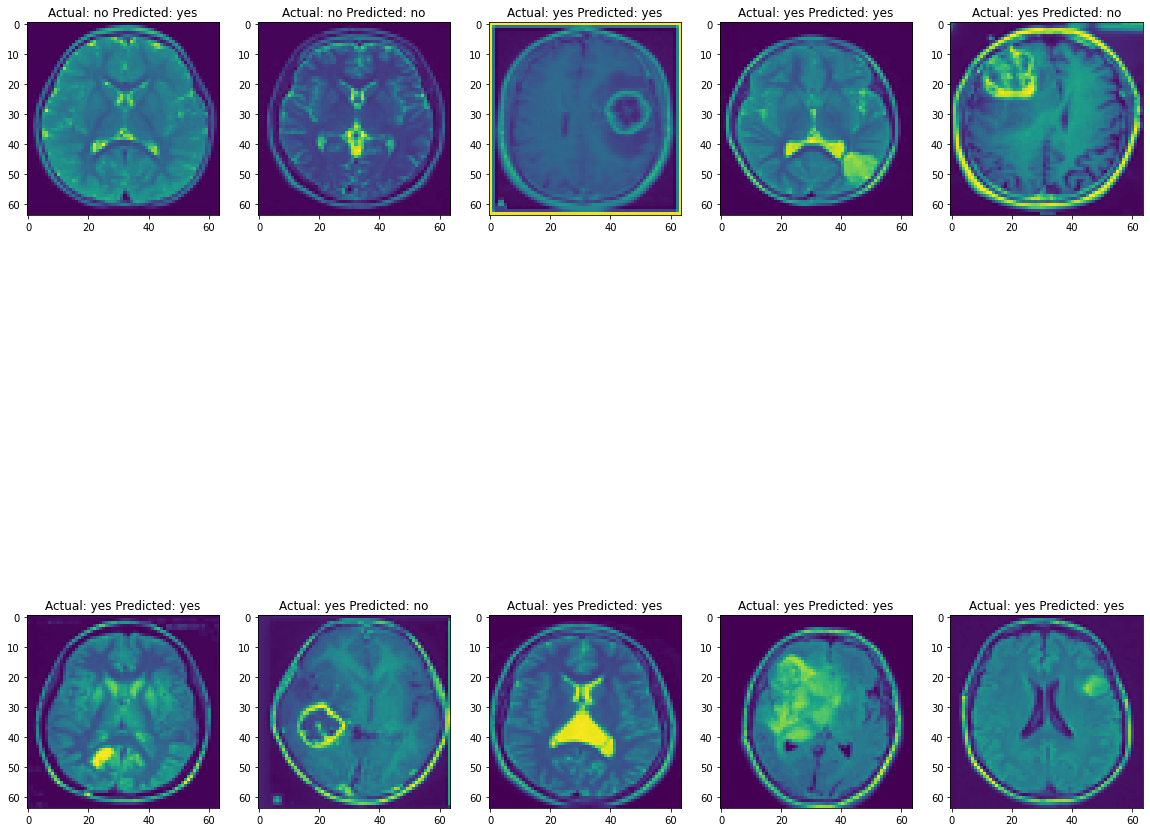

Time for inference: 1219.1403872966766


In [19]:
fig = plt.figure(figsize=(20,20))
for i in range(10):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(2,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")